## Step: Loading the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data():
    df_train = pd.read_csv('dataset/cleaned_train.csv')
    df_test = pd.read_csv('dataset/test.csv', encoding = "ISO-8859-1")

    return df_train, df_test

In [4]:
df_train, df_test = load_data()

In [5]:
df_train.shape

(250305, 11)

In [7]:
df_train.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

### PCA for Data Visualization

In [140]:
df_train.head()

,ticket_id,city,agency_name,violation_code,disposition,fine_amount,judgment_amount,late_fee,admin_fee,discount_amount,compliance
0,22056,4,1,1,1,250.0,305.0,25.0,20.0,0,0.0
1,27586,1,1,7,4,750.0,855.0,75.0,20.0,0,1.0
2,22062,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0
3,22084,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0
4,22093,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0


In [218]:
features = list(df_train.columns[1:-1])
#print(features)

x_pca = df_train.loc[:, features].values
y_pca = df_train.loc[:, ['compliance']].values

#scaler = MinMaxScaler()
scaler = StandardScaler()
x_pac = scaler.fit_transform(x_pca)

In [239]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x_pac)

principalDf = pd.DataFrame(data=principalComponents, columns=['comp1', 'comp2', 'comp3', 'comp4'])

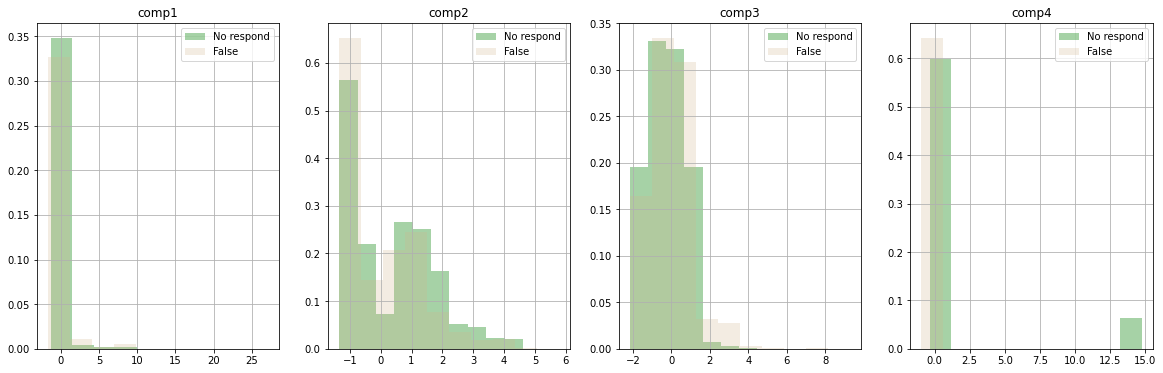

In [240]:
finalDf = pd.concat([principalDf, df_train[['compliance']]], axis = 1)

var = ['comp1', 'comp2', 'comp3', 'comp4']
finalDf_paid = finalDf[finalDf.compliance == 1]
finalDf_nopay = finalDf[finalDf.compliance == 0]

plt.subplots(1, 4, figsize=(20, 6))

for i, var in enumerate(var):
    plt.subplot(1, 4, i+1)
    finalDf_paid[var].hist(alpha=0.35, density=True, color='green', label='No respond')
    finalDf_nopay[var].hist(alpha=0.25, density=True, color='tan', label='False')
    plt.title(var)
    plt.legend()

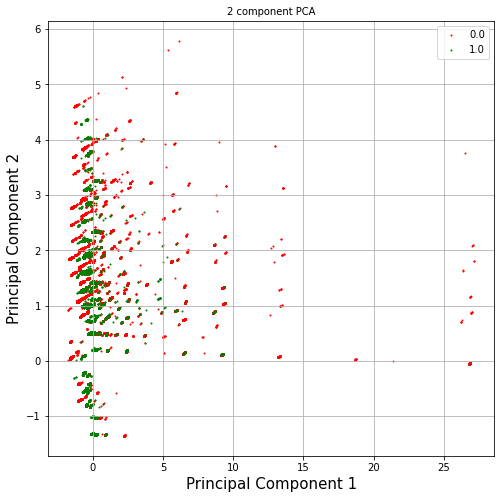

In [227]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 10)
targets = [0.0, 1.0]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['compliance'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

### PCA for Data Visualization

## Step: Apply modelling algorithms

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

## Resampling dataset

In [25]:
df_true = df_train[df_train.compliance == 1]
df_false = df_train[df_train.compliance != 1]
#df_null = df_train[df_train.compliance == -1]

#df_train.compliance.value_counts()
count_nopay, count_paid = df_train.compliance.value_counts()
print(count_paid, count_nopay)

11597 238708


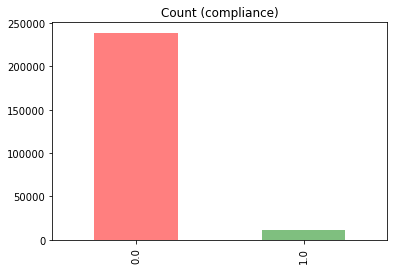

In [41]:
df_train.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Random under-sesampling

Random under-sampling:
1.0    11597
0.0    11597
Name: compliance, dtype: int64


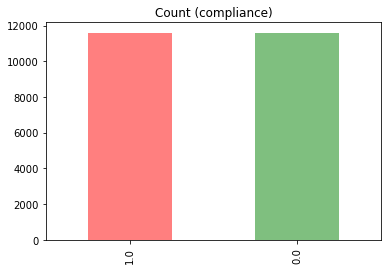

In [42]:
df_false_under = df_false.sample(count_paid)
df_train_under = pd.concat([df_false_under, df_true], axis=0)

print('Random under-sampling:')
print(df_train_under.compliance.value_counts())

df_train_under.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Random over-sesampling

Random under-sampling:
1.0    238708
0.0    238708
Name: compliance, dtype: int64


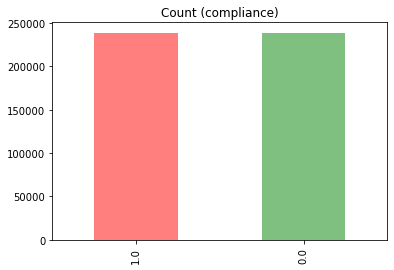

In [43]:
df_train_over = pd.concat([df_false, df_true.sample(count_nopay, replace=True)], axis=0)

print('Random under-sampling:')
print(df_train_over.compliance.value_counts())

df_train_over.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Python imblanced-learn module

In [44]:
import imblearn

### Random under-sampling and over-sampling with imbalanced-learn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sample_indices_=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

### Under-sampling: Tomek links

In [100]:
from imblearn.under_sampling import TomekLinks

tl, sample_indices_ = TomekLinks(sampling_strategy='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

TypeError: cannot unpack non-iterable TomekLinks object

### Under-sampling: Cluster Centroids

In [92]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy={0: 10})
X_cc, y_cc = cc.fit_sample(X, y)

### Over-sampling: SMOTE

In [127]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_sm, y_sm = smote.fit_sample(X, y)

### Over-sampling followed by under-sampling: STMOTE and Tomek

In [128]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto', random_state=0)
X_smt, y_smt = smt.fit_sample(X, y)

### Ready for training

In [163]:
X = df_train[df_train.columns[1:-1]]
y = df_train['compliance']

In [ ]:
#scaler = MinMaxScaler()
#X_train_norm = scaler.fit_transform(X_train)
#X_dev_norm = scaler.transform(X_dev)

In [129]:
def modelFit(X_train, X_dev, y_train, y_dev, clf, cv=5):
    clf = clf.fit(X_train, y_train)

    #ax = plt.gca()
    #roc = plot_roc_curve(clf, X_dev, y_dev, ax=ax, alpha=0.8)
    #plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    #plt.show()

    print('Cross-validation (AUC)', cross_val_score(clf, X_dev, y_dev, cv=cv, scoring = 'roc_auc'), 
          ', mean =', round(cross_val_score(clf, X_dev, y_dev, cv=cv, scoring = 'roc_auc').mean(), 3))
    cv_mean = round(cross_val_score(clf, X_dev, y_dev, cv=cv, scoring = 'roc_auc').mean(), 3)
    
    #conf_mat = confusion_matrix(y_true=y_dev, y_pred=clf.predict(X_dev))
    #print("Confusion matrix:\n", conf_mat)
    
    #acc = accuracy_score(y_dev, clf.predict(X_dev))
    #print("Accuracy: %.2f%%" %(acc *100.0))

    return cv_mean

In [93]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=0, test_size=0.05)
X_train_cc, X_dev_cc, y_train_cc, y_dev_cc = train_test_split(X_cc, y_cc, random_state=0, test_size=0.05)
X_train_sm, X_dev_sm, y_train_sm, y_dev_sm = train_test_split(X_sm, y_sm, random_state=0, test_size=0.05)
X_train_smt, X_dev_smt, y_train_smt, y_dev_smt = train_test_split(X_smt, y_smt, random_state=0, test_size=0.05)

In [79]:
clf_XGB = XGBClassifier()

In [132]:
auc_mean_baseline = modelFit(X_train, X_dev, y_train, y_dev, clf_XGB, cv=50)

Cross-validation (AUC) [0.7863607  0.94230769 0.85520362 0.90707822 0.86489981 0.9114415
 0.83031674 0.88671622 0.85778927 0.81722689 0.91839043 0.87152553
 0.93341952 0.91208791 0.90723982 0.86506141 0.80427171 0.93785014
 0.79639356 0.84068627 0.80864846 0.92787115 0.9112395  0.88112745
 0.8609944  0.85801821 0.85731793 0.88935574 0.87710084 0.81967787
 0.82020308 0.8317577  0.89145658 0.85014006 0.85539216 0.82352941
 0.86904762 0.83911064 0.76715686 0.8212535  0.85434174 0.87587535
 0.91369048 0.83893557 0.82177871 0.8422619  0.85259104 0.92296919
 0.90863356 0.7916261 ] , mean = 0.863


In [133]:
auc_mean_sm = modelFit(X_train_sm, X_dev_sm, y_train_sm, y_dev_sm, clf_XGB, cv=50)

Cross-validation (AUC) [0.85068368 0.86953972 0.86875186 0.85092004 0.87761087 0.85538456
 0.85520948 0.84446837 0.85369505 0.85645254 0.88012326 0.87337395
 0.85378259 0.87111543 0.82980549 0.85106886 0.83489154 0.85934135
 0.85907873 0.88187405 0.86477756 0.8752989  0.87910542 0.83305788
 0.85923764 0.86007279 0.84994726 0.87310127 0.86928622 0.85757736
 0.88669128 0.88305204 0.84898031 0.85500176 0.84714311 0.86001231
 0.84275668 0.85074719 0.88269163 0.84227321 0.87247714 0.8709564
 0.86992792 0.8457718  0.86114627 0.86686006 0.89196554 0.86576125
 0.86156821 0.86611287] , mean = 0.861


In [134]:
auc_mean_smt = modelFit(X_train_smt, X_dev_smt, y_train_smt, y_dev_smt, clf_XGB, cv=50)

Cross-validation (AUC) [0.85780572 0.87640076 0.87445721 0.87841434 0.85401492 0.861579
 0.88409616 0.88005148 0.8703775  0.90797906 0.85491665 0.87456226
 0.87471985 0.89136259 0.85622986 0.85980179 0.85333205 0.88965541
 0.87863321 0.84288766 0.87180885 0.86950559 0.85413883 0.87127259
 0.86777375 0.86886384 0.86927702 0.85210809 0.86708805 0.86216506
 0.85111471 0.86420459 0.85854315 0.85862493 0.85898541 0.86953578
 0.87656058 0.86947424 0.87882012 0.87438017 0.86658168 0.86906102
 0.8834447  0.87190962 0.871048   0.8758748  0.85881836 0.88983647
 0.84354669 0.85061544] , mean = 0.868


In [136]:
roc = plot_roc_curve(clf_XGB, X_dev, y_dev, ax=ax, alpha=0.8)
roc_sm = plot_roc_curve(clf_XGB, X_dev_sm, y_dev_sm, ax=ax, alpha=0.8)
roc_smt = plot_roc_curve(clf_XGB, X_dev_smt, y_dev_smt, ax=ax, alpha=0.8)

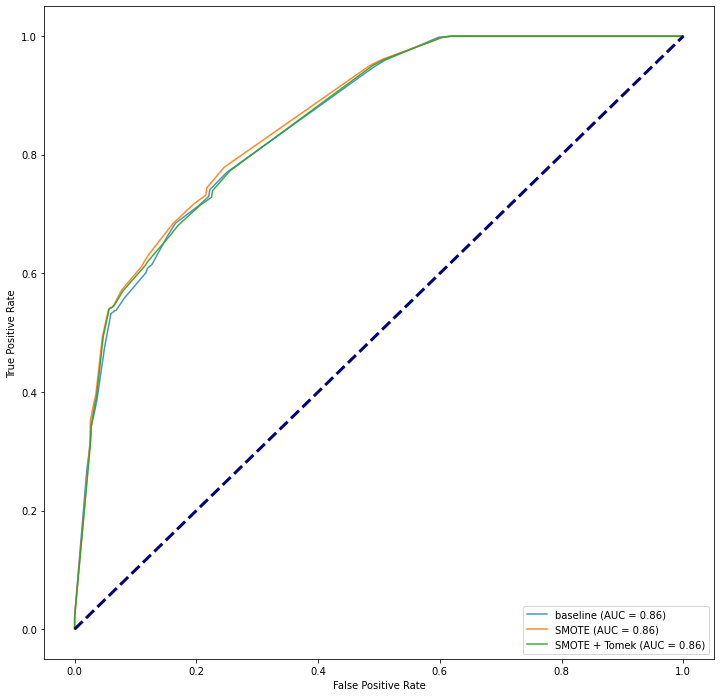

In [137]:
plt.subplots(1, 1, figsize=(12, 12))
ax = plt.gca()
roc.plot(ax=ax, alpha=0.8, name='baseline')
roc_sm.plot(ax=ax, alpha=0.9, name='SMOTE')
roc_smt.plot(ax=ax, alpha=0.9, name='SMOTE + Tomek')
#roc_XGB.plot(ax=ax, alpha=0.9)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()